# CNN

Epoch: 1/10, Train Loss: 1.2516, Train Accuracy: 43.75%, Val Loss: 1.1670, Val Accuracy: 54.81%
Epoch: 2/10, Train Loss: 1.0978, Train Accuracy: 54.90%, Val Loss: 1.0677, Val Accuracy: 59.36%
Epoch: 3/10, Train Loss: 0.9875, Train Accuracy: 60.49%, Val Loss: 1.0005, Val Accuracy: 61.76%
Epoch: 4/10, Train Loss: 0.8843, Train Accuracy: 65.55%, Val Loss: 0.9515, Val Accuracy: 63.64%
Epoch: 5/10, Train Loss: 0.7938, Train Accuracy: 69.51%, Val Loss: 0.9260, Val Accuracy: 62.30%
Epoch: 6/10, Train Loss: 0.7122, Train Accuracy: 74.03%, Val Loss: 0.8729, Val Accuracy: 66.04%
Epoch: 7/10, Train Loss: 0.6403, Train Accuracy: 76.54%, Val Loss: 0.8329, Val Accuracy: 68.72%
Epoch: 8/10, Train Loss: 0.5736, Train Accuracy: 79.55%, Val Loss: 0.8174, Val Accuracy: 68.45%
Epoch: 9/10, Train Loss: 0.5227, Train Accuracy: 80.87%, Val Loss: 0.8211, Val Accuracy: 67.38%
Epoch: 10/10, Train Loss: 0.4784, Train Accuracy: 83.30%, Val Loss: 0.7941, Val Accuracy: 70.32%


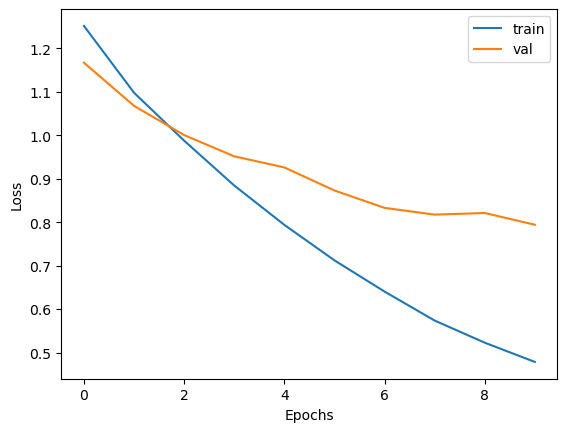

Test Accuracy: 70.23%
F1 Score: 0.6295


In [1]:
import numpy as np
import torch
from datasets import load_dataset
from torch.utils.data import DataLoader, TensorDataset
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.corpora import Dictionary
from torch import nn, optim
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import random
import gensim.downloader

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(50)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_texts(texts):
    processed_texts = []
    for text in texts:
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
        text = re.sub(r'\@\w+|\#', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        tokens = word_tokenize(text)
        tokens = [lemmatizer.lemmatize(word) for word in tokens if not word in stop_words]
        processed_texts.append(' '.join(tokens))
    return processed_texts

cache_dir = "./data_cache"
train_dataset = load_dataset("tweet_eval", name="emotion", split="train", cache_dir=cache_dir)
val_dataset = load_dataset("tweet_eval", name="emotion", split="validation", cache_dir=cache_dir)
test_dataset = load_dataset("tweet_eval", name="emotion", split="test", cache_dir=cache_dir)

train_texts = preprocess_texts(train_dataset['text'])
val_texts = preprocess_texts(val_dataset['text'])
test_texts = preprocess_texts(test_dataset['text'])

train_labels = np.array(train_dataset['label'])
val_labels = np.array(val_dataset['label'])
test_labels = np.array(test_dataset['label'])

def tokenize_and_build_vocab(texts):
    tokenized_texts = [list(word_tokenize(text)) for text in texts]
    dictionary = Dictionary(tokenized_texts)
    return tokenized_texts, dictionary

tokenized_train_texts, dictionary = tokenize_and_build_vocab(train_texts)
vocab_size = len(dictionary) + 1

def tokens_to_ids(tokenized_texts, dictionary):
    input_ids = []
    for tokens in tokenized_texts:
        ids = [dictionary.token2id[token] + 1 for token in tokens if token in dictionary.token2id]
        input_ids.append(ids)
    return input_ids

train_input_ids = tokens_to_ids(tokenized_train_texts, dictionary)
val_input_ids = tokens_to_ids([list(word_tokenize(text)) for text in val_texts], dictionary)
test_input_ids = tokens_to_ids([list(word_tokenize(text)) for text in test_texts], dictionary)

sequence_length = 30 

def pad_sequences(input_ids, sequence_length):
    padded_input_ids = []
    for ids in input_ids:
        if len(ids) > sequence_length:
            padded_input_ids.append(ids[:sequence_length])
        else:
            padded_input_ids.append([0] * (sequence_length - len(ids)) + ids)
    return padded_input_ids

train_input_ids = pad_sequences(train_input_ids, sequence_length)
val_input_ids = pad_sequences(val_input_ids, sequence_length)
test_input_ids = pad_sequences(test_input_ids, sequence_length)

train_inputs_tensor = torch.tensor(train_input_ids, dtype=torch.long)
train_labels_tensor = torch.tensor(train_labels, dtype=torch.long)
val_inputs_tensor = torch.tensor(val_input_ids, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels, dtype=torch.long)
test_inputs_tensor = torch.tensor(test_input_ids, dtype=torch.long)
test_labels_tensor = torch.tensor(test_labels, dtype=torch.long)

batch_size = 64
train_dataset = TensorDataset(train_inputs_tensor, train_labels_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataset = TensorDataset(val_inputs_tensor, val_labels_tensor)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = TensorDataset(test_inputs_tensor, test_labels_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



glove_vectors = gensim.downloader.load('glove-twitter-50')

embedding_matrix = np.zeros((vocab_size, glove_vectors.vector_size))
for word, idx in dictionary.token2id.items():
    if word in glove_vectors:
        embedding_matrix[idx + 1] = glove_vectors[word]

class CNNTextClassifier(nn.Module):
    def __init__(self, embedding_matrix, num_classes, filter_sizes=[2, 3, 4], num_filters=100):
        super(CNNTextClassifier, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(torch.tensor(embedding_matrix, dtype=torch.float32), freeze=False)
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (fs, embedding_matrix.shape[1])) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)
        x = [torch.relu(conv(x)).squeeze(3) for conv in self.convs]
        x = [torch.max_pool1d(line, line.size(2)).squeeze(2) for line in x]
        x = torch.cat(x, 1)
        x = self.dropout(x)
        x = self.fc(x)
        return x

num_classes = len(np.unique(train_labels))
model = CNNTextClassifier(embedding_matrix, num_classes)

def train_nn(num_epochs, model, train_dataloader, val_dataloader, learning_rate=0.0005):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    all_train_losses = []
    all_val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_losses = []
        total_correct = 0
        total_trained = 0

        for batch_input_ids, batch_labels in train_dataloader:
            optimizer.zero_grad()
            output = model(batch_input_ids)
            batch_loss = loss_fn(output, batch_labels)
            batch_loss.backward()
            optimizer.step()
            train_losses.append(batch_loss.item())

            predicted_labels = output.argmax(1)
            total_correct += (predicted_labels == batch_labels).sum().item()
            total_trained += batch_labels.size(0)

        train_accuracy = total_correct / total_trained * 100
        all_train_losses.append(np.mean(train_losses))

        model.eval()
        val_losses = []
        total_correct = 0
        total_trained = 0

        for val_input_ids, val_labels in val_dataloader:
            with torch.no_grad():
                val_output = model(val_input_ids)
                val_loss = loss_fn(val_output, val_labels)
                val_losses.append(val_loss.item())

                predicted_labels = val_output.argmax(1)
                total_correct += (predicted_labels == val_labels).sum().item()
                total_trained += val_labels.size(0)

        val_accuracy = total_correct / total_trained * 100
        all_val_losses.append(np.mean(val_losses))

        print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {np.mean(train_losses):.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {np.mean(val_losses):.4f}, Val Accuracy: {val_accuracy:.2f}%")

    return model, all_train_losses, all_val_losses

num_epochs = 10
trained_model, train_losses, val_losses = train_nn(num_epochs, model, train_loader, val_loader)

plt.figure()
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('Measure of Loss CNN',dpi=300, bbox_inches='tight')
plt.show()

def evaluate_model(model, test_loader):
    model.eval()
    total_correct = 0
    total_tested = 0
    gold_labels = []
    pred_labels = []

    for test_input_ids, test_labels in test_loader:
        with torch.no_grad():
            test_output = model(test_input_ids)
            predicted_labels = test_output.argmax(1)
            gold_labels.extend(test_labels.tolist())
            pred_labels.extend(predicted_labels.tolist())
            total_correct += (predicted_labels == test_labels).sum().item()
            total_tested += test_labels.size(0)

    accuracy = total_correct / total_tested * 100
    return accuracy, gold_labels, pred_labels

test_accuracy, gold_labels, pred_labels = evaluate_model(trained_model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

f1 = f1_score(gold_labels, pred_labels, average='macro')
print(f"F1 Score: {f1:.4f}")